***SYSTEM RECOMMENDATION GAMES***

![](https://cdn.hobbyconsolas.com/sites/navi.axelspringer.es/public/styles/1200/public/media/image/2020/03/chrono-trigger-1889953.jpeg?itok=4DhVMhD0)

**Task 1**: finding similar games

**Task 2**: finding similar users

**Task 3**: Recommending Games for a random user

In [2]:
import pandas as pd
import numpy as np

**Import Data**

In [3]:
score_df = pd.read_csv("../input/score-games/score.csv",encoding = "ISO-8859-1")

score_df.head(5)

,game_id,Title,Platform,Userscore,Comment,Username
0,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,"Everything in OoT is so near at perfection, it...",SirCaestus
1,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I won't bore you with what everyone is already...,Kaistlin
2,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Anyone who gives the masterpiece below a 7 or ...,Jacody
3,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,I'm one of those people who think that this is...,doodlerman
4,0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,This game is the highest rated game on Metacr...,StevenA


In [4]:
score_df.dtypes, score_df.shape

(game_id       int64
 Title        object
 Platform     object
 Userscore     int64
 Comment      object
 Username     object
 dtype: object,
 (677705, 6))

In [5]:
n_score = score_df['Username'].value_counts()
score_df = score_df[score_df['Username'].isin(n_score[n_score >= 10].index)].copy()
len(score_df)

307379

In [6]:
# Scaling BTW (0 , 1.0)
min_score = min(score_df['Userscore'])
max_score = max(score_df['Userscore'])
score_df['Userscore'] = score_df["Userscore"].apply(lambda x: (x - min_score) / (max_score - min_score)).values.astype(np.float64)

Avgscore = np.mean(score_df['Userscore'])
print('Avg', Avgscore)

Avg 0.7705035152032333


In [7]:
# Removing Duplicated Rows
duplicates = score_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    score_df = score_df[~duplicates]

print('> {} duplicates'.format(score_df.duplicated().sum()))

> 6027 duplicates
> 0 duplicates


In [8]:
# Eliminates columns
score_df.drop(["Title","Platform","Comment"],axis=1,inplace=True)

**DATA PREPROCESSING**

In [9]:
# Encoding categorical data
user_ids = score_df["Username"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
score_df["user"] = score_df["Username"].map(user2user_encoded)
n_users = len(user2user_encoded)

game_ids = score_df["game_id"].unique().tolist()
game2game_encoded = {x: i for i, x in enumerate(game_ids)}
game_encoded2game = {i: x for i, x in enumerate(game_ids)}
score_df["game"] = score_df["game_id"].map(game2game_encoded)
n_games = len(game2game_encoded)

print("Num of users: {}, Num of games: {}".format(n_users, n_games))
print("Min score: {}, Max score: {}".format(min(score_df['Userscore']), max(score_df['Userscore'])))

Num of users: 13432, Num of games: 4008
Min score: 0.0, Max score: 1.0


In [10]:
# Shuffle
score_df = score_df.sample(frac=1, random_state=73)

X = score_df[['user', 'game']].values
y = score_df["Userscore"]

In [11]:
# Split
test_set_size = int(len(score_df)*(20/100)) 
train_indices = score_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

print('> Train set scores: {}'.format(len(y_train)))
print('> Test set scores: {}'.format(len(y_test)))

> Train set scores: 241082
> Test set scores: 60270


In [12]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [13]:
#pip install tensorflow==2.4.1

In [14]:
# Accelerator check
import tensorflow as tf

TPU_INIT = True

if TPU_INIT:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    #tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    !nvidia-smi
    
print(tf.__version__)

2022-05-20 20:08:15.345111: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-20 20:08:15.345330: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-20 20:08:21.352819: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-20 20:08:21.355691: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-05-20 20:08:21.355728: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 20:08:21.355761: I tensorflow/stream_executor/cuda/cud

2.4.1


In [15]:
pip install keras==2.3.1

     |████████████████████████████████| 377 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 50 kB 2.7 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


**MODE BUILDING**

In [16]:
#import keras
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers 
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

In [17]:
# Embedding layers
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def RecommenderNet():
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    game = Input(name = 'game', shape = [1])
    game_embedding = Embedding(name = 'game_embedding',
                       input_dim = n_games, 
                       output_dim = embedding_size)(game)
    
    #x = Concatenate()([user_embedding, game_embedding])
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, game_embedding])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, game], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

In [18]:
if TPU_INIT:    
    with tpu_strategy.scope():
        model = RecommenderNet()
else:
    model = RecommenderNet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
game (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 128)       1719296     user[0][0]                       
__________________________________________________________________________________________________
game_embedding (Embedding)      (None, 1, 128)       513024      game[0][0]                       
______________________________________________________________________________________________

In [19]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping,   
]

In [20]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
3014/3014 [==============================] - 69s 21ms/step - loss: 0.7178 - mae: 0.3607 - mse: 0.1601 - val_loss: 0.7117 - val_mae: 0.3585 - val_mse: 0.1578
Epoch 2/20
3014/3014 [==============================] - 62s 21ms/step - loss: 0.6776 - mae: 0.3418 - mse: 0.1413 - val_loss: 0.6484 - val_mae: 0.3262 - val_mse: 0.1269
Epoch 3/20
3014/3014 [==============================] - 63s 21ms/step - loss: 0.5811 - mae: 0.2756 - mse: 0.0952 - val_loss: 0.5419 - val_mae: 0.2375 - val_mse: 0.0795
Epoch 4/20
3014/3014 [==============================] - 63s 21ms/step - loss: 0.4343 - mae: 0.1534 - mse: 0.0342 - val_loss: 0.4546 - val_mae: 0.1598 - val_mse: 0.0439
Epoch 5/20
3014/3014 [==============================] - 62s 21ms/step - loss: 0.3865 - mae: 0.1048 - mse: 0.0190 - val_loss: 0.4190 - val_mae: 0.1252 - val_mse: 0.0315
Epoch 6/20
3014/3014 [==============================] - 63s 21ms/step - loss: 0.3775 - mae: 0.0945 - mse: 0.0172 - val_loss: 0.4030 - val_mae: 0.1112 - val_mse:

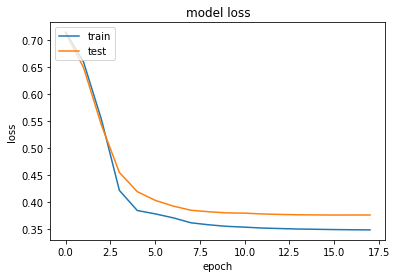

In [21]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

**Extracting weights from model**

In [22]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

game_weights = extract_weights('game_embedding', model)
user_weights = extract_weights('user_embedding', model)

**GAMES META DATA**

In [23]:
df = pd.read_csv('../input/data-games/juegos.csv')
df.head(10)

,game_id,Title,Year,Developer,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.5,01-feb
2,2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.8,1 Player
3,3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.5,01-feb
4,4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player
5,5,Super Mario Galaxy,2007,Nintendo,Action;Platformer;Platformer;3D;3D,Wii,97,9.1,No Online Multiplayer
6,6,Super Mario Galaxy 2,2010,NintendoEADTokyo,Action;Platformer;Platformer;3D;3D,Wii,97,9.1,No Online Multiplayer
7,7,Red Dead Redemption 2,2018,RockstarGames,Action Adventure;Open-World,XboxOne,97,8.1,Up to 32
8,8,Grand Theft Auto V,2013,RockstarNorth,Action Adventure;Modern;Open-World,XboxOne,97,7.8,Up to 30
9,9,Grand Theft Auto V,2021,RockstarNorth,Modern;Action Adventure;Modern;Open-World,PlayStation3,97,8.3,Up to 16


In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df[df["Metascore"]=="not specified"]

,game_id,Title,Year,Developer,Genre,Platform,Metascore,Avg_Userscore,No_Players
11100,11100,No Mans Land,2003,SelectiveIntuition,Action;General,PC,not specified,tbd,No Online Multiplayer
11425,11425,Dracula Origin,2019,BigFishGames,Adventure;General,PC,not specified,6.6,not specified


In [26]:
col=df[df["Metascore"]=="not specified"].index

df.drop(col, inplace=True)

df["Metascore"] = df["Metascore"].astype(float)

df.shape

(12398, 9)

In [27]:
df[df["Avg_Userscore"]=="not specified"]

,game_id,Title,Year,Developer,Genre,Platform,Metascore,Avg_Userscore,No_Players
452,452,13 Sentinels: Aegis Rim,2021,Vanillaware,Adventure;General,Switch,90.0,not specified,not specified


In [28]:
df.loc[df["Avg_Userscore"]=="not specified","Avg_Userscore"] =df.loc[df["Avg_Userscore"]=="not specified","Metascore"]/10

In [29]:
df[df["Avg_Userscore"]=="tbd"]

,game_id,Title,Year,Developer,Genre,Platform,Metascore,Avg_Userscore,No_Players
971,971,Tiger Woods PGA Tour 2005,2004,EASports,Sports;Traditional;Golf;Sim,GameCube,88.0,tbd,01-abr
1301,1301,NASCAR 2005: Chase for the Cup,2004,EATiburon,Driving;Racing;Stock Car,Xbox,86.0,tbd,01-feb
1498,1498,Moto Racer Advance,2002,DelphineSoftwareInternational,Driving;Racing;Motorcycle;Street,GameBoyAdvance,86.0,tbd,not specified
2247,2247,Pinball FX 2: Marvel Pinball - Vengeance and V...,2011,ZenStudios,Pinball;Action;Miscellaneous;Parlor;Pinball,Xbox360,84.0,tbd,not specified
2350,2350,NASCAR Thunder 2003,2002,EASports,Driving;Racing;Stock Car,Xbox,84.0,tbd,01-abr
...,...,...,...,...,...,...,...,...,...
12371,12371,Doraemon: Story of Seasons,2020,Brownies,Strategy;Management;Business / Tycoon,PlayStation4,68.0,tbd,No Online Multiplayer
12372,12372,Edna & Harvey: The Breakout - 10th Anniversary...,2020,"DaedalicEntertainment,TheKnightsofUnity",Adventure;General;Point-and-Click,Switch,68.0,tbd,No Online Multiplayer
12391,12391,Midway Arcade Treasures 3,2005,DigitalEclipse,Miscellaneous;Compilation,Xbox,68.0,tbd,01-abr
12392,12392,Terminator 3: The Redemption,2004,ParadigmEntertainment,Action;Shooter;Third-Person;Sci-Fi,GameCube,68.0,tbd,01-feb


In [30]:
df.loc[df["Avg_Userscore"]=="tbd","Avg_Userscore"] =df.loc[df["Avg_Userscore"]=="tbd","Metascore"]/10

df["Avg_Userscore"] = df["Avg_Userscore"].astype(float)

In [31]:
df.loc[df["No_Players"]=="not specified"]

,game_id,Title,Year,Developer,Genre,Platform,Metascore,Avg_Userscore,No_Players
12,12,Tony Hawk's Pro Skater 2,2017,Treyarch,Sports;Alternative;Skateboarding,Dreamcast,97.0,6.2,not specified
15,15,Perfect Dark,2018,RareLtd.,Action;Shooter;First-Person;Sci-Fi,Nintendo64,97.0,8.8,not specified
22,22,NFL 2K1,2015,VisualConcepts,Sports;Traditional;Football;Sim,Dreamcast,97.0,6.1,not specified
55,55,The Legend of Zelda: A Link to the Past,2013,Capcom,Action Adventure;Fantasy,GameBoyAdvance,95.0,9.0,not specified
60,60,Tony Hawk's Pro Skater 2,2014,VicariousVisions,Sports;Alternative;Skateboarding,GameBoyAdvance,95.0,6.7,not specified
...,...,...,...,...,...,...,...,...,...
12380,12380,Kromaia Omega,2015,KrakenEmpire,Action;Shooter;Rail,PlayStation4,68.0,5.9,not specified
12382,12382,Assassin's Creed Unity: Dead Kings,2015,"Ubisoft,UbisoftMontreal",Action Adventure;Historic;Open-World,PlayStation4,68.0,6.5,not specified
12385,12385,Bejeweled Blitz Live,2011,TorpexGamesLLC,Miscellaneous;Puzzle;Puzzle;Puzzle;Matching;Ma...,Xbox360,68.0,7.5,not specified
12386,12386,Tenchu: Shadow Assassins,2009,"FromSoftware,Acquire",Action Adventure;Historic;General;Historic,PSP,68.0,7.1,not specified


In [32]:
dict_players={'01-feb':'1 Player','01-abr':'1 Player','01-ago':'1 Player', 'ene-16':'1 Player',
                'ene-24':'1 Player', '01-jun':'1 Player','ene-32':'1 Player'}

df['No_Players'].replace(dict_players,inplace=True)

In [33]:
cols = ["game_id", "Title", "Genre", "Platform"]
Platform_df = pd.read_csv('../input/data-games/juegos.csv', usecols=cols)

def getPlatform(game):
    if isinstance(game, int):
        return Platform_df[Platform_df.game_id == game].Platform.values[0]
    if isinstance(game, str):
        return Platform_df[Platform_df.Title == game].Platform.values[0]

In [34]:
Platform_df.head(5)

,game_id,Title,Genre,Platform
0,0,The Legend of Zelda: Ocarina of Time,Action Adventure;Fantasy,Nintendo64
1,1,Tony Hawk's Pro Skater 2,Sports;Alternative;Skateboarding,PlayStation
2,2,Grand Theft Auto IV,Action Adventure;Modern;Modern;Open-World,PlayStation3
3,3,SoulCalibur,Action;Fighting;3D,Dreamcast
4,4,Grand Theft Auto IV,Action Adventure;Modern;Modern;Open-World,Xbox360


In [35]:
df.sort_values(by=['Avg_Userscore'], 
               inplace=True,
               ascending=False, 
               kind='quicksort',
               na_position='last')

In [36]:
df = df[["game_id", "Title", "Genre","Platform","Avg_Userscore"]]

In [37]:
def getGameFrame(game):
    if isinstance(game, int):
        return df[df.game_id == game]
    if isinstance(game, str):
        return df[df.Title == game]

**TASK 1**

In [38]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_games(Title, n=10, return_dist=False, neg=False):
    try:
        index = getGameFrame(Title).game_id.values[0]
        encoded_index = game2game_encoded.get(index)
        weights = game_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('games closest to {}'.format(Title))

        if return_dist:
            return dists, closest
        
        rindex = df

        SimilarityArr = []

        for close in closest:
            decoded_id = game_encoded2game.get(close)
            Platform = getPlatform(decoded_id)
            game_frame = getGameFrame(decoded_id)
            
            game_name = game_frame.Title.values[0]
            genre = game_frame.Genre.values[0]
            similarity = dists[close]
            SimilarityArr.append({"game_id": decoded_id, "Title": game_name,
                                  "similarity": similarity,"Genre": genre,"Platform":Platform})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.game_id != index].drop(['game_id'], axis=1)

    except:
        print('{}!, Not Found in game list'.format(Title))

![](https://img.g2a.com/600x351/1x1x0/grand-theft-auto-iv-complete-edition-steam-gift-europe/5a5e164d5bafe3e1964b0505)

In [39]:
find_similar_games('Grand Theft Auto IV', n=10, neg=False)

games closest to Grand Theft Auto IV


,Title,similarity,Genre,Platform
9,Grand Theft Auto IV,0.942058,Action Adventure;Modern;Modern;Open-World,PlayStation3
8,Grand Theft Auto IV,0.907177,Action Adventure;Modern;Modern;Open-World,PC
7,Neverwinter Nights 2,0.361457,Role-Playing;PC-style RPG;PC-style RPG;Western-Style,PC
6,Super Street Fighter IV,0.317841,Action;Fighting;Fighting;3D;2D;3D,PlayStation3
5,Tom Clancy's Ghost Recon 2,0.316727,Action;Shooter;First-Person;Tactical;Modern,Xbox
4,Heroes of Might and Magic IV,0.307443,Strategy;Turn-Based;Fantasy;General;Fantasy,PC
3,Ultimate Marvel vs. Capcom 3,0.302713,Action;Fighting;Fighting;2D;2D,Xbox360
2,Geometry Wars: Retro Evolved,0.293222,Action;Shooter;Shooter;Static;Static;Shoot-'Em-Up;Top-Down,Xbox360
1,Full Spectrum Warrior,0.292926,Strategy;Real-Time;Military,Xbox
0,World of Warcraft: Legion,0.283396,Role-Playing;Miscellaneous;Massively Multiplayer;Board / Card Game,PC


**TASK 2**

In [47]:
print('> picking up random user')

scores_per_user = score_df.groupby('Username').size()
random_user = scores_per_user[scores_per_user < 500].sample(1, random_state=None).index[0]
print('> Username:', random_user)

> picking up random user
> Username: Kcon


In [48]:
#pd.reset_option('all')
pd.set_option("max_colwidth", None)

def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user2user_encoded.get(index)
        weights = user_weights
    
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> users similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = df
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, str):
                decoded_id = user_encoded2user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print('{}!, Not Found in User list'.format(item_input))

In [49]:
similar_users = find_similar_users(str(random_user), 
                                   n=5, 
                                   neg=False)

similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != random_user]
similar_users.head(5)

> users similar to #Kcon


,similar_users,similarity
4,Ccx55,0.593254
3,MajorTom03,0.556663
2,Mudpooch,0.536397
1,earbus,0.525217
0,Phix105,0.519881


**USER PREFERENCES**

In [50]:
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.pyplot as plt

def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700, height=400, 
                             background_color='white', 
                             colormap='gnuplot').generate_from_frequencies(all_genres)
    
    plt.figure(figsize=(10,8)) 
    plt.imshow(genres_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def getFavGenre(frame, plot=False):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genres_list = []
        for genres in frame['Genre']:
            if isinstance(genres, str):
                for genre in genres.split(','):
                    genres_list.append(genre)
                    all_genres[genre.strip()] += 1    
        if plot:
            showWordCloud(all_genres)
        
        return genres_list

    
def get_user_preferences(user_id, plot=False, verbose=0):
    games_played_by_user = score_df[score_df.Username==user_id]
    user_rating_percentile = np.percentile(games_played_by_user.Userscore, 75)
    games_played_by_user = games_played_by_user[games_played_by_user.Userscore >= user_rating_percentile]
    top_games_user = (
        games_played_by_user.sort_values(by="Userscore", ascending=False)#.head(10)
        .game_id.values
    )
    
    game_df_rows = df[df["game_id"].isin(top_games_user)]
    game_df_rows = game_df_rows[["Title", "Genre"]]
    
    if verbose != 0:
        print("> User #{} has rated {} games (avg. rating = {:.1f})".format(
          user_id, len(games_played_by_user),
          games_played_by_user['Userscore'].mean(),
        ))
    
        print('> preferred genres')
    
    if plot:
        getFavGenre(game_df_rows, plot)
        
    return game_df_rows

> User #Kcon has rated 4 games (avg. rating = 0.2)
> preferred genres


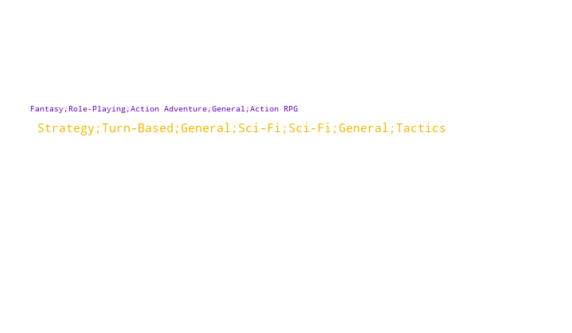

> games highly rated by this user


,Title,Genre
204,Bloodborne,Fantasy;Role-Playing;Action Adventure;General;Action RPG
503,XCOM: Enemy Unknown,Strategy;Turn-Based;General;Sci-Fi;Sci-Fi;General;Tactics
558,XCOM: Enemy Unknown,Strategy;Turn-Based;General;Sci-Fi;Sci-Fi;General;Tactics
673,XCOM: Enemy Unknown,Strategy;Turn-Based;General;Sci-Fi;Sci-Fi;General;Tactics


In [51]:
user_pref = get_user_preferences(random_user, plot=True, verbose=1)
print('> games highly rated by this user')

pd.DataFrame(user_pref).head(5)

**TASK 3**

In [52]:

def get_recommended_games(similar_users, n=10):
    recommended_games = []
    game_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(str(user_id), verbose=0)
        pref_list = pref_list[~ pref_list.Title.isin(user_pref.Title.values)]
        game_list.append(pref_list.Title.values)
        
    game_list = pd.DataFrame(game_list)
    sorted_list = pd.DataFrame(pd.Series(game_list.values.ravel()).value_counts()).head(n)
    
    for i, game_name in enumerate(sorted_list.index):        
        n_user_pref = sorted_list[sorted_list.index == game_name].values[0][0]
        if isinstance(game_name, str):
            try:
                frame = getGameFrame(game_name)
                game_id = frame.game_id.values[0]
                genre = frame.Genre.values[0]
                recommended_games.append({  "n": n_user_pref,
                                            "game_name": game_name, 
                                            "Genre": genre})
            except:
                pass
    
    return pd.DataFrame(recommended_games)

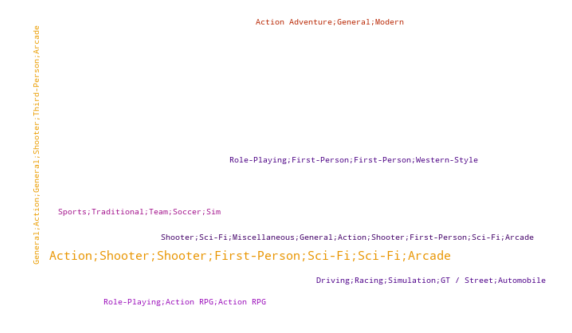


> Top recommendations for user: Kcon


,n,game_name,Genre
0,6,BioShock Infinite,Action;Shooter;Shooter;First-Person;Sci-Fi;Sci-Fi;Arcade
1,4,The Elder Scrolls V: Skyrim,Role-Playing;First-Person;First-Person;Western-Style
2,3,Portal 2,Action;Shooter;Shooter;First-Person;Sci-Fi;Sci-Fi;Arcade
3,3,Mass Effect 3,Role-Playing;Action RPG;Action RPG
4,3,FIFA 15,Sports;Traditional;Team;Soccer;Sim
5,3,Titanfall,Shooter;Sci-Fi;Miscellaneous;General;Action;Shooter;First-Person;Sci-Fi;Arcade
6,2,Half-Life 2,Action;Shooter;Shooter;First-Person;Sci-Fi;Sci-Fi;Arcade
7,1,The Last of Us Remastered,Action Adventure;General;Modern
8,1,Forza Horizon 2,Driving;Racing;Simulation;GT / Street;Automobile
9,1,Sunset Overdrive,General;Action;General;Shooter;Third-Person;Arcade


In [53]:
recommended_games = get_recommended_games(similar_users, n=10)
getFavGenre(recommended_games, plot=True)

print('\n> Top recommendations for user: {}'.format(random_user))
recommended_games

**RANKING BASED RECOMMENDATION**

In [54]:
print("Showing recommendations for user: {}".format(random_user))
print("===" * 25)

games_played_by_user = score_df[score_df.Username==random_user]
game_not_played_df = df[
    ~df["game_id"].isin(games_played_by_user.game_id.values)
]

game_not_played = list(
    set(game_not_played_df['game_id']).intersection(set(game2game_encoded.keys()))
)

game_not_played = [[game2game_encoded.get(x)] for x in game_not_played]

user_encoder = user2user_encoded.get(random_user)

user_game_array = np.hstack(
    ([[user_encoder]] * len(game_not_played), game_not_played)
)

user_game_array = [user_game_array[:, 0], user_game_array[:, 1]]
ratings = model.predict(user_game_array).flatten()

top_ratings_indices = (-ratings).argsort()[:10]

recommended_game_ids = [
    game_encoded2game.get(game_not_played[x][0]) for x in top_ratings_indices
]

Results = []
top_rated_ids = []

for index, game_id in enumerate(game_not_played):
    rating = ratings[index]
    id_ = game_encoded2game.get(game_id[0])
    
    if id_ in recommended_game_ids:
        top_rated_ids.append(id_)
        try:
            condition = (df.game_id == id_)
            Title = df[condition]['Title'].values[0]
            genre = df[condition].Genre.values[0]
            score = df[condition].Avg_Userscore.values[0]
        except:
            continue
            
        Results.append({"Title": Title, 
                        "pred_rating": rating,
                        "genre": genre})

print("---" * 25)
print("> Top 10 games recommendations")
print("---" * 25)


Results = pd.DataFrame(Results).sort_values(by='pred_rating', ascending=False)
Results

Showing recommendations for user: Kcon
---------------------------------------------------------------------------
> Top 10 games recommendations
---------------------------------------------------------------------------


,Title,pred_rating,genre
5,Castle Crashers Remastered,0.973932,Action;Beat-'Em-Up;2D
1,Tiger Woods PGA Tour 2003,0.972762,Sports;Traditional;Individual;Golf;Sim;Sim
6,Crusader Kings II,0.968167,Strategy;Real-Time;Historic;General;Historic
4,NBA Jam: On Fire Edition,0.967490,Sports;Traditional;Team;Basketball;Arcade;Arcade
9,Empire Earth,0.966922,Strategy;Real-Time;Historic;General;Historic
2,NCAA Football 2003,0.965883,Sports;Traditional;Football;Sim
7,Ratchet: Deadlocked,0.963902,Action;Shooter;Third-Person;Sci-Fi
3,"Sam & Max Episode 205: What's New, Beelzebub?",0.963643,Adventure;General;3D;Point-and-Click;Third-Person
8,Peter Jackson's King Kong: The Official Game of the Movie,0.962846,Action Adventure;Modern
0,World of Goo,0.962524,Miscellaneous;Puzzle;Action;Puzzle;General;Puzzle;General


**Save Model**

In [ ]:
#model.save('game_model.h5')

In [ ]:
#from IPython.display import FileLink
#FileLink(r'./game_model.h5')